This notebook is by Anastasia Ruzmaikina.

In this notebook we use the Naive Bayes Classifier to classify a wine as 'high quality' or 'low quality' based on eleven attributes such as density, sulfates, alhohol, fixed acidity etc. We use a data set of 6496 wines.

The Naive Bayes Model is not a very good predictor of the quality of the wine. The best accuracy it achieves is 68%.


In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

First we load the data and understand the data.

In [23]:
wine = pd.read_csv('wine.csv')

In [24]:
wine.shape

(6497, 14)

In [25]:
wine.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,high_quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,0
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red,0
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red,0
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red,1
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,0


The column 'Unnamed: 0' carries no new information, so we drop it.



In [26]:
wine.drop(['Unnamed: 0'], axis=1, inplace=True)

In [27]:
# Get count of missing values in every column
print(wine.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
color                   0
high_quality            0
dtype: int64


We can look at the column statistics.

In [28]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.633061
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


Now we proceed with the exploratory data analysis.



In [29]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
 12  high_quality          6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


The column 'color' is categorical, so we do a one hot encoding to get two numerical columns: 'color_red' and 'color_white'.

In [30]:
color_dummies= pd.get_dummies(data=wine, columns=['color'])
wine = color_dummies

In [31]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,0,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,0,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,0,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,0,1


We take a look at the target column.

In [32]:
# The high_quality is the target column y.
wine.high_quality.value_counts()

1    4113
0    2384
Name: high_quality, dtype: int64

We can plot a pie chart for the distribution of values in the 'high_quality' column.

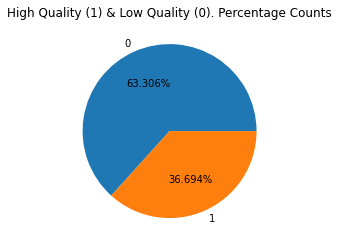

In [33]:
# get the set of distinct classes
labels = wine.high_quality.unique()

# get the count of each class
sizes = wine.high_quality.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('High Quality (1) & Low Quality (0). Percentage Counts')
plt.show()

Plot the histograms of the columns.

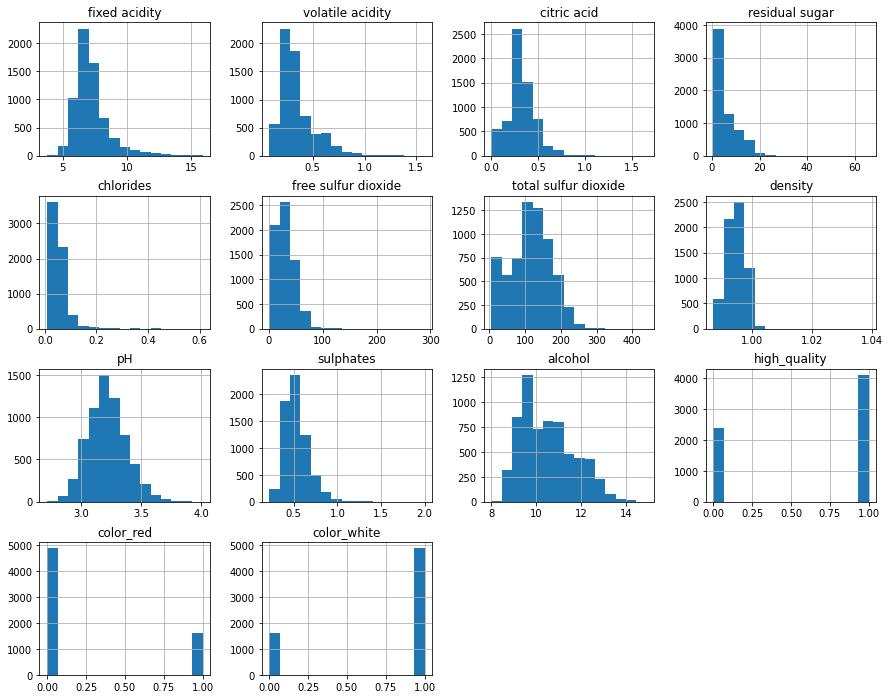

In [34]:
# plot histograms of the variables

wine.hist(figsize=(15,12),bins = 15)

plt.show()

Data Preprocessing.

In [35]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'high_quality', 'color_red',
       'color_white'],
      dtype='object')

First we rescale the data using the Standard Scaler to make sure that the columns with higher values do not have a disproportionate effect on the target variable.

We assign the first eleven columns and 13th and 14th column as predictors X. We assign the 12th column 'high_quality' as a target variable y.



In [36]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
wine.iloc[:, 0:11] = StandardScaler().fit_transform(wine.iloc[:, 0:11])
data_matrix = wine.values

# X: feature matrix (for this analysis, we exclude the 'high_value' variable from the dataset)
X = data_matrix[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]]

# y: labels vector
y = data_matrix[:, 11]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

wine.head()

X.shape= (6497, 13) y.shape= (6497,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,0,1,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,0,1,0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1,1,0
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0


We split the data into the training set and the test set.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (4547, 13) Y_train.shape= (4547,)
X_test.shape= (1950, 13) Y_test.shape= (1950,)


In [38]:
X_train

array([[-0.01053015,  0.07215247, -0.03962261, ...,  0.12985765,
         0.        ,  0.11838474],
       [ 0.01291513,  0.16537786, -0.09272478, ..., -0.07538551,
         0.09064952,  0.        ],
       [-0.01442952, -0.05259747,  0.11441724, ..., -0.07224917,
         0.        ,  0.08687814],
       ...,
       [ 0.02831043, -0.08673205,  0.00089735, ..., -0.09533464,
         0.        ,  0.09540016],
       [-0.02159846,  0.00816314, -0.13301837, ..., -0.08633665,
         0.        ,  0.13004131],
       [-0.04316135, -0.01609408,  0.06616879, ...,  0.18166882,
         0.        ,  0.13472328]])

Model Building

Gaussian Naive Bayes Model



In [40]:
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

Predicting values

In [41]:
# Predicting the test and trained values
y_pred = gnb.predict(X_test)

In [42]:
y_pred[0:100]

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.])

In [43]:
y_test[0:100]

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.])


Model Performance

In [44]:
from   sklearn.metrics import accuracy_score, confusion_matrix , classification_report

# Evaluate the model
def compute_evaluation_metric(y_actual, y_predicted):
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))

In [45]:
compute_evaluation_metric(y_test, y_pred)


 Accuracy Score :  0.678974358974359

 Confusion Matrix : 
 [[382 334]
 [292 942]]

 Classification Report : 
               precision    recall  f1-score   support

         0.0       0.57      0.53      0.55       716
         1.0       0.74      0.76      0.75      1234

    accuracy                           0.68      1950
   macro avg       0.65      0.65      0.65      1950
weighted avg       0.68      0.68      0.68      1950



Bernoulli Naive Bayes Model

In [46]:
# Import BernoulliNB 
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

# Fit into the model
bnb.fit(X_train, y_train)

BernoulliNB()

In [47]:
# Predicting the test and trained values
y_pred = bnb.predict(X_test)

In [48]:
# Model Evaluation
compute_evaluation_metric(y_test, y_pred)


 Accuracy Score :  0.6584615384615384

 Confusion Matrix : 
 [[312 404]
 [262 972]]

 Classification Report : 
               precision    recall  f1-score   support

         0.0       0.54      0.44      0.48       716
         1.0       0.71      0.79      0.74      1234

    accuracy                           0.66      1950
   macro avg       0.62      0.61      0.61      1950
weighted avg       0.65      0.66      0.65      1950



Conclusion: The Naive Bayes Model is not a very good predictor of the quality of the wine. The best accuracy it achieves is 68%

The reason the Naive Bayes Classifier is not accurate for this data set is that the assumption that the features are independent is not correct.

